<a href="https://colab.research.google.com/github/Ruma13/skin_cancer-tl/blob/main/ResNet_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


Epoch 1/10 | Train Loss: 0.4127, Train Acc: 0.8138 | Val Loss: 0.3261, Val Acc: 0.8788
Epoch 2/10 | Train Loss: 0.3119, Train Acc: 0.8601 | Val Loss: 0.2947, Val Acc: 0.8939
Epoch 3/10 | Train Loss: 0.2933, Train Acc: 0.8658 | Val Loss: 0.2888, Val Acc: 0.9091
Epoch 4/10 | Train Loss: 0.2698, Train Acc: 0.8874 | Val Loss: 0.3459, Val Acc: 0.8636
Epoch 5/10 | Train Loss: 0.2514, Train Acc: 0.8908 | Val Loss: 0.2710, Val Acc: 0.9091
Epoch 6/10 | Train Loss: 0.2498, Train Acc: 0.8881 | Val Loss: 0.2647, Val Acc: 0.9318
Epoch 7/10 | Train Loss: 0.2264, Train Acc: 0.9018 | Val Loss: 0.2110, Val Acc: 0.9394
Epoch 8/10 | Train Loss: 0.2183, Train Acc: 0.9090 | Val Loss: 0.2418, Val Acc: 0.9167
Epoch 9/10 | Train Loss: 0.2163, Train Acc: 0.9090 | Val Loss: 0.4023, Val Acc: 0.8409
Epoch 10/10 | Train Loss: 0.2008, Train Acc: 0.9158 | Val Loss: 0.2684, Val Acc: 0.8864
              precision    recall  f1-score   support

      benign       0.96      0.78      0.86       281
   malignant       0

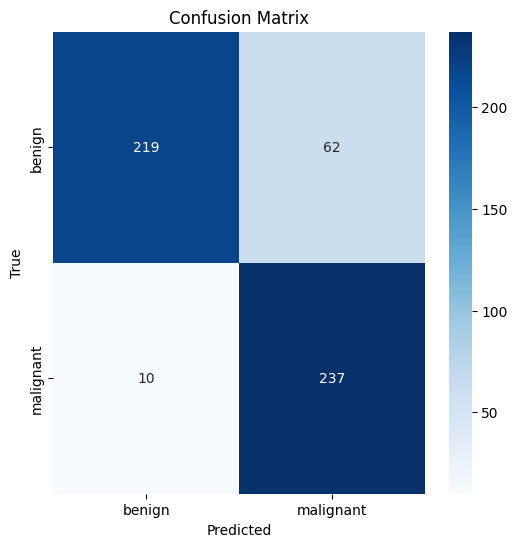

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive


train_dir = "/content/drive/MyDrive/Colab Dataset/train"
test_dir = "/content/drive/MyDrive/Colab Dataset/test"


train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transforms)

val_size = int(0.2 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, final_test_dataset = random_split(test_dataset, [val_size, test_size])

class_counts = np.bincount([label for _, label in train_dataset.imgs])
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset.imgs]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(final_test_dataset, batch_size=32, shuffle=False)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)
        channel_att = torch.sigmoid(self.channel_mlp(avg_pool) + self.channel_mlp(max_pool)).view(b, c, 1, 1)
        x = x * channel_att
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = torch.sigmoid(self.spatial_conv(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial_att


class FusionNet(nn.Module):
    def __init__(self, num_classes):
        super(FusionNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze backbone
        self.resnet.fc = nn.Identity()  # Remove FC

        self.cbam = CBAMBlock(2048)

        self.mid_cnn = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.resnet(x)
        features = features.view(features.size(0), 2048, 1, 1)
        attn_features = self.cbam(features)
        mid_features = self.mid_cnn(attn_features)
        flat = torch.flatten(mid_features, 1)
        return self.fc(flat)

num_classes = len(train_dataset.classes)
model = FusionNet(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter("runs/skin_cancer_experiment")


EPOCHS = 10

def train_model(model, train_loader, val_loader, criterion, optimizer, device, writer):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0

    for epoch in range(EPOCHS):

        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)


        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)


        writer.add_scalars("Loss", {"train": epoch_loss, "val": val_loss}, epoch)
        writer.add_scalars("Accuracy", {"train": epoch_acc, "val": val_acc}, epoch)

        print(f"Epoch {epoch+1}/{EPOCHS} | "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, writer
)


model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
